In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


In [41]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/StockData/NOK.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'High']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

In [42]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:]

# Tiến hành huấn luyện mô hình SARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['High']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

In [43]:
import pmdarima as pm
import statsmodels.api as sm

#Tìm mô hình SARIMAX tốt nhất
model = auto_arima(y_train, exogenous=exog_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình SARIMAX (đảm bảo rằng seasonal_order được đặt nếu bạn muốn sử dụng SARIMAX)
model_fit = SARIMAX(y_train, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order).fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-897.034, Time=2.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-869.905, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-897.169, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-893.086, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-871.831, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-898.515, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-897.179, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-895.153, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-900.032, Time=0.18 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-898.658, Time=0.63 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=-898.665, Time=0.91 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-896.643, Time=1.27 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=-898.267, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-898.114, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0

In [44]:
x_test = np.array(test_data.index).reshape(-1, 1)

# Dự đoán trên tập kiểm thử (test_data)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['High']).reshape(-1, 1)
y_pred_test = model_fit.predict(start=train_size, end=train_size+len(test_data)-1, exog=exog_test)
y_pred_test

array([4.75939239, 4.70281985, 4.7642404 , 4.78507777, 4.69391311,
       4.70460738, 4.76373194, 4.74223329, 4.70999294, 4.79059651,
       4.81209099, 4.81209096, 4.75835502, 4.69387189, 4.69924548,
       4.64013594, 4.65625673, 4.68849829, 4.71536627, 4.69924548,
       4.69387189, 4.67237751, 4.59714719, 4.67237751, 4.69924548,
       4.71536627, 4.73148705, 4.95717801, 4.9679252 , 4.97329879,
       4.93031004, 4.99479317, 4.98941958, 4.98941958, 5.02703474,
       4.99479317, 5.00016677, 5.02166114, 5.02166114, 5.03240833,
       4.98404598, 5.00016677, 5.01628755, 4.99479317, 4.95180442,
       4.97867239, 4.95180442, 4.95180442, 4.92493645, 4.86045331,
       4.88732128, 4.8765741 , 4.91956285, 4.91418926, 4.80671737,
       4.81746456, 4.93031004, 4.89269488, 4.92493645, 4.8712005 ,
       4.88732128, 4.88732128, 4.93568363, 4.98404598, 4.93031004,
       4.8712005 , 4.84970612, 4.75835502, 4.71536627, 4.6831247 ,
       4.6831247 , 4.61326797, 4.51654327, 4.50579609, 4.51654

In [45]:
# Dự đoán giá 30 ngày tiếp theo

next_dates = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')

mean_volume = np.mean(df['High'])
exog_next = np.full((30, 1), mean_volume)
# Tính chỉ số bắt đầu và kết thúc cho dự đoán
start_index = len(df) - len(y_test)
end_index = len(df) - 1

# Tạo mảng exogenous kết hợp cho tập kiểm thử và 30 ngày tiếp theo
exog_combined = np.concatenate((exog_test, exog_next))

# Dự đoán cho tập kiểm thử và 30 ngày tiếp theo
y_pred_combined = model_fit.predict(start=train_size, end=train_size + len(test_data) + 29, exog=exog_combined)

# Tách phần dự đoán cho 30 ngày tiếp theo
y_pred_next_30_days = y_pred_combined[-30:]

# Chuẩn bị DataFrame cho đồ thị
next_30_days = pd.DataFrame({'Date': next_dates, 'Predicted_Close': y_pred_next_30_days})
y_pred_combined



array([4.75939239, 4.70281985, 4.7642404 , 4.78507777, 4.69391311,
       4.70460738, 4.76373194, 4.74223329, 4.70999294, 4.79059651,
       4.81209099, 4.81209096, 4.75835502, 4.69387189, 4.69924548,
       4.64013594, 4.65625673, 4.68849829, 4.71536627, 4.69924548,
       4.69387189, 4.67237751, 4.59714719, 4.67237751, 4.69924548,
       4.71536627, 4.73148705, 4.95717801, 4.9679252 , 4.97329879,
       4.93031004, 4.99479317, 4.98941958, 4.98941958, 5.02703474,
       4.99479317, 5.00016677, 5.02166114, 5.02166114, 5.03240833,
       4.98404598, 5.00016677, 5.01628755, 4.99479317, 4.95180442,
       4.97867239, 4.95180442, 4.95180442, 4.92493645, 4.86045331,
       4.88732128, 4.8765741 , 4.91956285, 4.91418926, 4.80671737,
       4.81746456, 4.93031004, 4.89269488, 4.92493645, 4.8712005 ,
       4.88732128, 4.88732128, 4.93568363, 4.98404598, 4.93031004,
       4.8712005 , 4.84970612, 4.75835502, 4.71536627, 4.6831247 ,
       4.6831247 , 4.61326797, 4.51654327, 4.50579609, 4.51654

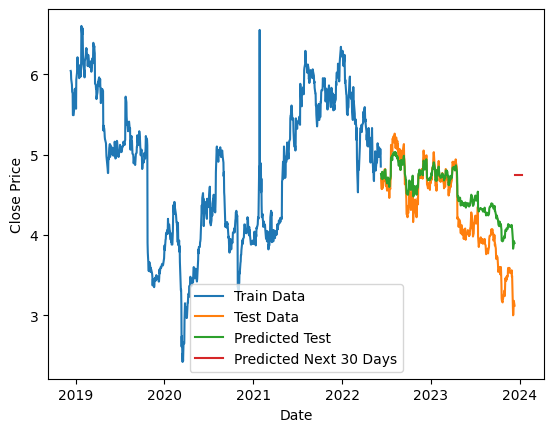

In [46]:
# Vẽ đồ thị
#plt.figure(figsize=(15, 8))
plt.plot(train_data['Date'], train_data['Close'], label='Train Data')
plt.plot(test_data['Date'], test_data['Close'], label='Test Data')
plt.plot(test_data['Date'], y_pred_test, label='Predicted Test')
plt.plot(next_30_days['Date'], next_30_days['Predicted_Close'], label='Predicted Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [47]:
# Tính MAE
test_mae = mean_absolute_error(y_test, y_pred_test)

# Tính toán RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Làm tròn đến số thứ 3 sau dấu phẩy
test_mae = round(test_mae, 3)
test_rmse = round(test_rmse, 3)
test_mape = round(test_mape, 3)

print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 0.245
Testing RMSE: 0.318
Testing MAPE: 6.326


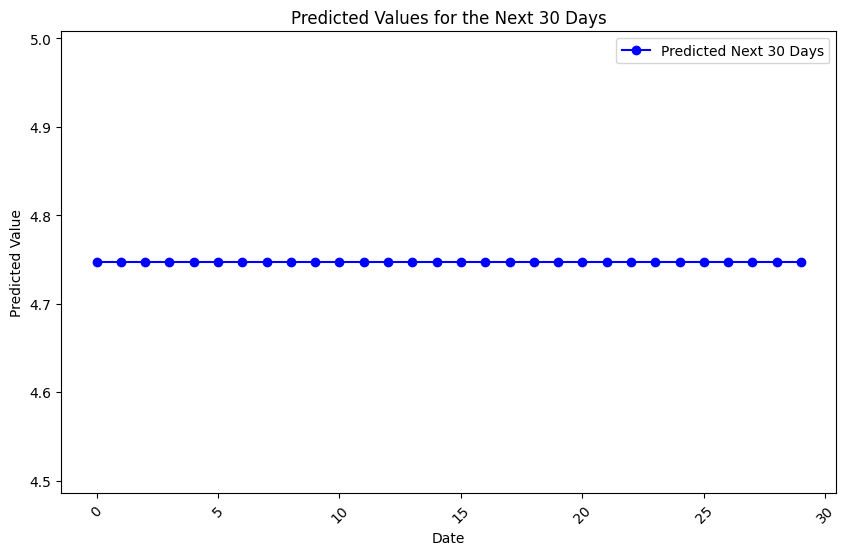

In [48]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6)) # Set the figure size
plt.plot(y_pred_next_30_days, marker='o', color='b', label='Predicted Next 30 Days')

# Đặt tiêu đề và nhãn
plt.title('Predicted Values for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.legend()

# Hiển thị biểu đồ
plt.show()


